# IV) Non-linear magnetostatics

_______
## 1) Equation

We want to solve the following weak formulation, i.e., find $a\in H^1_0 (\Omega)$ such that

$$ \forall v\in H^1_0(\Omega) , \quad \int_\Omega \nu(|\nabla a|^2) \nabla a \cdot \nabla v = \int_\Omega v j $$

with $\nu$ the magnetic reluctivity, which is
- $ \nu = \nu_0 $ in air and conductors
- $ \nu(b^2) = 100 + 10 \exp(1.8 b^2 ) $ in iron

and $j$ the current density that is
- $ j = 0 $ in air and iron
- $ j= +J $ in positive conductor
- $ j = -J$ in negative conductor
  
with $J = 10\;A/mm^2$. 

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw

________
## 2) Geometry

Without airgap, there is a risk of saturation !

In [25]:
from utils.myGeometries import gapedInductor
mesh = gapedInductor(airgap = 0, h = 0.01) # no airgap
Draw(mesh.MaterialCF({"condN":1, "iron":2, "condP":3}), mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

Get the names of regions and boundaries

In [3]:
mesh.GetMaterials()   # region names

('air', 'iron', 'condP', 'condN')

In [4]:
mesh.GetBoundaries()   # boundaries names

('out',
 'out',
 'out',
 'out',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '')

________
## 3) Linear formulation

Assume first $\nu_{iron} = \frac{\nu_0}{1000}$
Let's formulate and solve the problem!

In [5]:
nu0 = 1/(4e-7 * pi)  # m/H
nu_iron = nu0 / 1000
J = 10e6 # A/m^2
R = CoefficientFunction( ((0,1),(-1,0)), dims = (2,2))

### a) Function space

In [6]:
fes = H1(mesh, dirichlet = "out")

### b) Weak form

In [7]:
a = fes.TrialFunction()
v = fes.TestFunction()

In [8]:
bf = BilinearForm(fes)
bf += nu0 * grad(a) * grad(v) * dx("air|condP|condN")
bf += nu_iron * grad(a) * grad(v) * dx("iron")

lf = LinearForm(fes)
lf += v * J * dx("condP") - v * J * dx("condN")

### c) Assemble and solve the system

In [ ]:
lf.Assemble()
bf.Assemble()

sol = GridFunction(fes)
sol.vec.data = bf.mat.Inverse(freedofs = fes.FreeDofs(), inverse = "sparsecholesky") * lf.vec
Draw(sol, settings = { "Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

In [10]:
Draw(R * grad(sol), mesh, 
     vectors={"grid_size" : 50, "offset" : 0.5 },
     settings = { "Objects" : { "Wireframe" : False, "Surface" : False }})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

_____
## 4) Nonlinear formulation


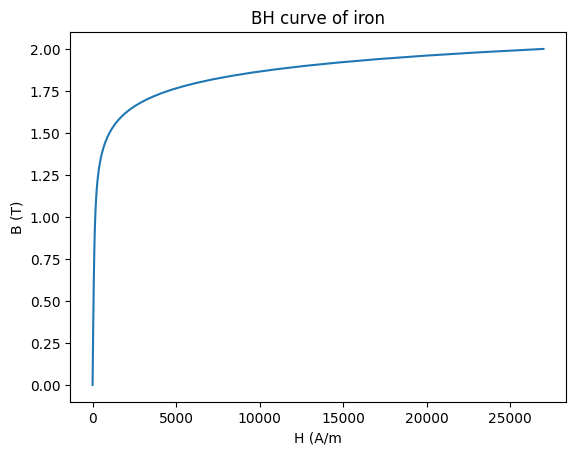

In [11]:
def nu_iron(b2):
    return 100 + 10 * exp(1.8 * b2)

def dnu_iron_db2(b2):
    return 18 * exp(1.8 * b2)

import numpy as np
import matplotlib.pyplot as plt
b = np.linspace(0,2,100)
plt.plot(nu_iron(b**2) * b, b); plt.xlabel("H (A/m"); plt.ylabel("B (T)")
plt.title("BH curve of iron"); plt.show()

### a) Weak form and directional derivative

In [ ]:
def residual(a, v) :
    b2 = grad(a)**2
    res =  grad(v) * nu0 * grad(a) * dx("air|condP|condN")
    res += grad(v) * nu_iron(b2) * grad(a) * dx("iron")
    res += -v * J * dx("condP") + v * J * dx("condN")
    return res

In [ ]:
def d_residual(da, v, aOld):
    b2 = grad(aOld)**2
    dres =  grad(v) * nu0 * grad(da) * dx("air|condP|condN")
    dres += grad(v) * nu_iron(b2) * grad(da) * dx("iron")
    dres += 2 * grad(v) * dnu_iron_db2(b2) * (grad(aOld) * grad(da)) * grad(aOld) * dx("iron")
    return dres

### b) Simple Newton

In [14]:
# initialization
fes = H1(mesh, dirichlet = "out")
da = fes.TrialFunction()
v = fes.TestFunction()

sol = GridFunction(fes)
resList = []

In [ ]:
# loop
step = 0.01
tol = 1e-8
maxit = 100
for i in range(maxit):
    # compute and assemble residual and derivatives
    res = LinearForm(residual(sol, v)).Assemble()
    dres = BilinearForm(d_residual(da, v, sol)).Assemble()

    # compute norm of the residual
    resList.append(np.linalg.norm(res.vec.FV().NumPy()[fes.FreeDofs()]))
    
    # compute descent direction
    d = dres.mat.Inverse(freedofs = fes.FreeDofs(), inverse = "sparsecholesky") * res.vec

    # update
    sol.vec.data += - step * d
    print(f"{i = } | res = {resList[-1]:.5e} | {step = :.2e}")
    
    # simple step control
    if i>0 and resList[-1] < resList[-2]:
        step = min(1, 1.2*step)
    else : 
        step = step/2

    # simple stop criterion based on the norm of residual
    if resList[-1] < tol:
        break

i = 0 | res = 1.46788e+02 | step = 1.00e-02
i = 1 | res = 1.45457e+02 | step = 5.00e-03
i = 2 | res = 1.44713e+02 | step = 6.00e-03
i = 3 | res = 1.43828e+02 | step = 7.20e-03
i = 4 | res = 1.42776e+02 | step = 8.64e-03
i = 5 | res = 1.41527e+02 | step = 1.04e-02
i = 6 | res = 1.40044e+02 | step = 1.24e-02
i = 7 | res = 1.38285e+02 | step = 1.49e-02
i = 8 | res = 1.36203e+02 | step = 1.79e-02
i = 9 | res = 1.33744e+02 | step = 2.15e-02
i = 10 | res = 1.30849e+02 | step = 2.58e-02
i = 11 | res = 1.27451e+02 | step = 3.10e-02
i = 12 | res = 1.23481e+02 | step = 3.72e-02
i = 13 | res = 1.18867e+02 | step = 4.46e-02
i = 14 | res = 1.13540e+02 | step = 5.35e-02
i = 15 | res = 1.07436e+02 | step = 6.42e-02
i = 16 | res = 1.00507e+02 | step = 7.70e-02
i = 17 | res = 9.27311e+01 | step = 9.24e-02
i = 18 | res = 8.41254e+01 | step = 1.11e-01
i = 19 | res = 7.47607e+01 | step = 1.33e-01
i = 20 | res = 6.47785e+01 | step = 1.60e-01
i = 21 | res = 5.44043e+01 | step = 1.92e-01
i = 22 | res = 4.395

Is it converging? 
- If not how to make it converge?
- If yes, at what rate?

**Hint** : from the linear problem, compute $\nu_{iron}$

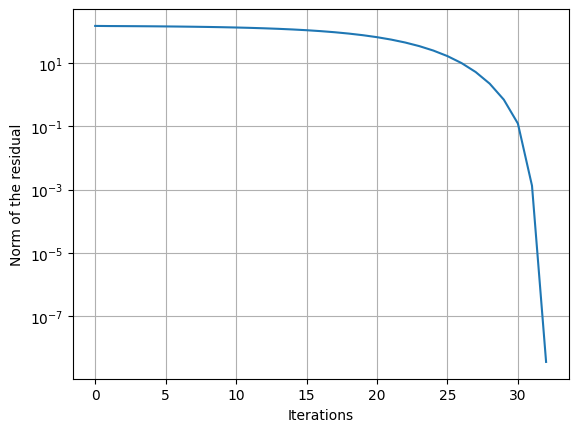

In [16]:
plt.semilogy(resList)
plt.grid()
plt.xlabel("Iterations"); plt.ylabel("Norm of the residual");
plt.show()

In [17]:
Draw(R * grad(sol), mesh, 
     vectors={"grid_size" : 50, "offset" : 0.5 },
     settings = { "Objects" : { "Wireframe" : False, "Surface" : False }})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

_________
### c) More elaborated Newton
We can improve by adding : 
- more stopping criteria
- proper linesearch

You can analyze the algorithm in the file `utils\mySolver`, and make some comments.

In [18]:
from utils.mySolvers import solve

result = solve(fes, residual, verbosity = 3)

-------------------- START NEWTON ---------------------
Initializing  ..... done (8.40 ms).
Initial residual : 1.46788e+02
Start loop  ....... 
 It 1 -------------------------------------------------
 - Assembly ....... done (10.30 ms).
 - Solve .......... done (16.34 ms).
 - Line search .... 
   it 0 : ||residual|| = nan | step = 1.00e+00
   it 1 : ||residual|| = nan | step = 5.00e-01
   it 2 : ||residual|| = nan | step = 2.50e-01
   it 3 : ||residual|| = nan | step = 1.25e-01
   it 4 : ||residual|| = 2.16767e+95 | step = 6.25e-02
   it 5 : ||residual|| = 5.67251e+22 | step = 3.12e-02
   it 6 : ||residual|| = 3.48396e+04 | step = 1.56e-02
   it 7 : ||residual|| = 1.45623e+02 | step = 7.81e-03
 - Line search done (34.70 ms).
 - Conv : ||residual|| = 1.45623e+02 | decr = 1.48152e+01
 - Newton iteration done (73.18 ms).
 It 2 -------------------------------------------------
 - Assembly ....... done (10.41 ms).
 - Solve .......... done (12.09 ms).
 - Line search .... 
   it 0 : ||residua

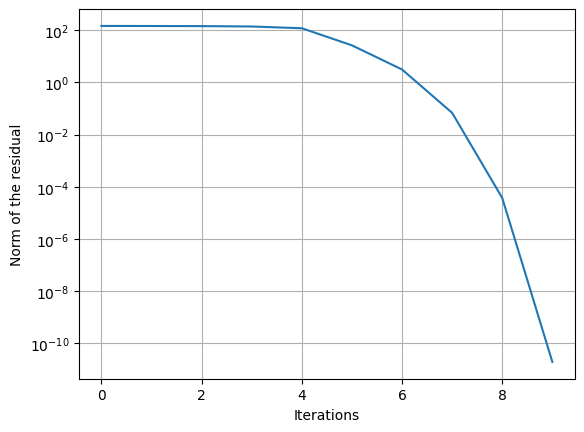

In [19]:
plt.semilogy(result["residual"])
plt.grid()
plt.xlabel("Iterations"); plt.ylabel("Norm of the residual");
plt.show()

In [20]:
Draw(R * grad(result["solution"]), mesh, 
     vectors={"grid_size" : 50, "offset" : 0.5 },
     settings = { "Objects" : { "Wireframe" : False, "Surface" : False }})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene